## Plotting functions
In this Jupyter Notebook I have implemented some functions for inspecting the `OneSLAM` results.

In [8]:
from numthreads import set_num_threads
set_num_threads(1)

import pickle
import numpy as np
from glob import glob
from scipy.spatial.transform import Rotation as R

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection

#### Helpers

In [ ]:
def plot_cmap_3d(
        x: np.ndarray,
        y: np.ndarray,
        z: np.ndarray,
        c: np.ndarray,
        **lc_kwargs
) -> Line3DCollection:
    """Add a line plot color-coded according to a given array in 3D space.

    Args:
        x: Points in the x-axis.
        y: Points in the y-axis.
        z: Points in the z-axis.
        c: Array from which color is assigned.

    Returns:
        Color-coded segments forming a line plot.
    """
    points = np.vstack([x, y, z]).T
    segments = np.stack([points[:-1], points[1:]], axis=1)
    lc = Line3DCollection(
        segments,
        norm=plt.Normalize(vmin=c.min(), vmax=c.max()),
        **lc_kwargs
    )
    lc.set_array(c)
    return lc

def plot_cmap(
        x: np.ndarray,
        y: np.ndarray,
        c: np.ndarray,
        **lc_kwargs
) -> LineCollection:
    """Add a line plot color-coded according to a given array.

    Args:
        x: Points in the x-axis.
        y: Points in the y-axis.
        c: Array from which color is assigned.

    Returns:
        Color-coded segments forming a line plot.
    """
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(
        segments,
        norm=plt.Normalize(vmin=c.min(), vmax=c.max()),
        **lc_kwargs
    )
    lc.set_array(c)
    return lc

def load_poses(pkl_path: str) -> list:
    """Load poses from pickle file.
    
    Args:
        pkl_path: Path to pickle file.

    Returns:
        List of pose poses.
    """
    with open(pkl_path, "rb") as f:
        data = pickle.load(f)
    poses = []
    for elem in data.values():
        poses.append(elem[0])
    return poses

def relative_motion(poses):
    """Compute relative motion frame-to-frame.
    
    Args:
        poses: List of pose poses.
    
    Returns:
        Frame-to-frame translations and rotations.
    """
    trans = []
    rot = []
    for i in range(1, len(poses)):
        T_rel = np.linalg.inv(poses[i-1]) @ poses[i]
        trans.append(np.linalg.norm(T_rel[:3, 3]))
        rot.append(np.degrees(R.from_matrix(T_rel[:3,:3]).magnitude()))
    return np.array(trans), np.array(rot)

#### Camera pose in 3D space

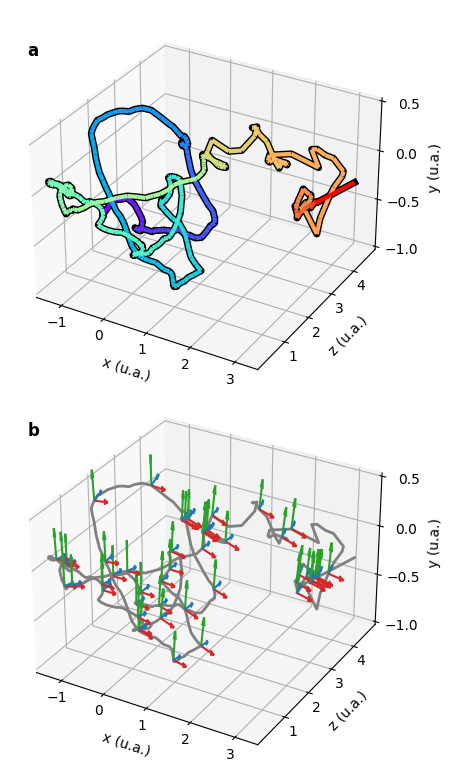

In [11]:
# Load pose
data = np.loadtxt(
    "./results/exp_02062026_14:04:40/poses_pred.txt",
    comments="#"
)

# Extract data
times = data[:, 0]
positions = data[:, 1:4]
quaternions = data[:, 4:8]
x, y, z = positions[:, 0], positions[:, 2], -positions[:, 1]

# Plotting
fig = plt.figure(figsize=(5, 10))
gs = GridSpec(2, 1, figure=fig)
ax = fig.add_subplot(gs[0], projection="3d", computed_zorder=False)

# Trajectory
ax.plot(x, y, z, 'k', lw=5)
lc = plot_cmap_3d(
    x,
    y,
    z,
    times,
    lw=3,
    cmap='rainbow',
    zorder=2
)
ax.add_collection(lc)
ax.set_xlabel('x (u.a.)', labelpad=-2)
ax.set_ylabel('z (u.a.)', labelpad=-2)
ax.set_zlabel('y (u.a.)')
ax.set_xlim(-1.5, 3.4)
ax.set_ylim(0, 5)
ax.set_zlim(-1, 0.49)
ax.set_ylim(0.01, 4.9)
ax.set_xticks([-1, 0, 1, 2, 3])
ax.set_yticks([1, 2, 3, 4])
ax.set_zticks([-1, -0.5, 0, 0.5])
ax.set_box_aspect([1, 1, 0.7])
ax.view_init(elev=30)
ax.tick_params(axis='x', pad=-3)
ax.tick_params(axis='y', pad=-3)

# Rotations
ax = fig.add_subplot(gs[1], projection="3d", computed_zorder=False)
ax.plot(x, y, z, 'grey', lw=2)
scale = 0.3
step = 10
for i in range(0, len(positions), step):
    r = R.from_quat(quaternions[i])
    r = r.as_matrix()
    t = (positions[i][0], positions[i][2], -positions[i][1])
    ax.quiver(*t, *r[:, 0], color='tab:red', length=scale)
    ax.quiver(*t, *r[:, 2], color='tab:green', length=scale)
    ax.quiver(*t, *r[:, 1], color='tab:blue', length=scale)
ax.set_xlabel('x (u.a.)', labelpad=-2)
ax.set_ylabel('z (u.a.)', labelpad=-2)
ax.set_zlabel('y (u.a.)')
ax.set_xlim(-1.5, 3.4)
ax.set_ylim(0, 5)
ax.set_zlim(-1, 0.49)
ax.set_ylim(0.01, 4.9)
ax.set_xticks([-1, 0, 1, 2, 3])
ax.set_yticks([1, 2, 3, 4])
ax.set_zticks([-1, -0.5, 0, 0.5])
ax.set_box_aspect([1, 1, 0.7])
ax.view_init(elev=30)
ax.tick_params(axis='x', pad=-3)
ax.tick_params(axis='y', pad=-3)

# Empty ax for extra left padding
ax = fig.add_subplot([0.9, 0.5, 0.1, 0.1])
ax.set_axis_off()

# Text
fig.text(0.16, 0.83, 'a', weight='bold', fontsize=12)
fig.text(0.16, 0.45, 'b', weight='bold', fontsize=12)

# # Colorbar
# ax = fig.add_subplot([0.55, 0.81, 0.4, 0.05])
# ax.set_axis_off()
# fig.colorbar(
#     plt.cm.ScalarMappable(
#         norm=mcolors.Normalize(vmin=0, vmax=66),
#         cmap='rainbow'
#     ),
#     ax=ax,
#     fraction=0.5,
#     shrink=1,
#     pad=0,
#     label='Tiempo (s)',
#     orientation='horizontal',
#     location='top'   
# )

fig.subplots_adjust(hspace=-0.05)
fig.savefig(
    './results/camera_poses.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)

#### Camera pose projected in 2D space

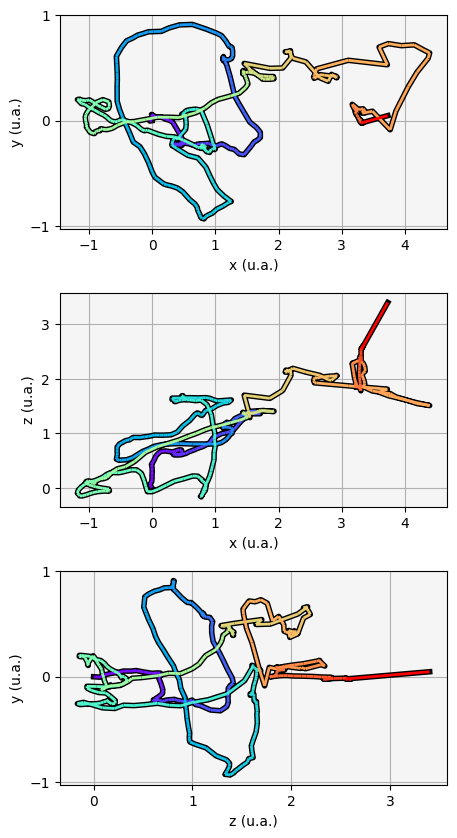

In [7]:
# Load pose
data = np.loadtxt(
    "./results/exp_02062026_14:04:40/poses_pred.txt",
    comments="#"
)

# Extract data
times = data[:, 0]
positions = data[:, 1:4]
quaternions = data[:, 4:8]
x, y, z = positions[:, 0], positions[:, 2], -positions[:, 1]

# Plotting
fig = plt.figure(figsize=(5, 10))
gs = GridSpec(3, 1, figure=fig)

ax = fig.add_subplot(gs[0])
ax.plot(x, z, 'k-', lw=4)
lc = plot_cmap(x, z, times, lw=2, cmap='rainbow')
ax.add_collection(lc)
ax.set_xlabel('x (u.a.)')
ax.set_ylabel('y (u.a.)')
ax.set_yticks([-1, 0, 1])
ax.set_facecolor('whitesmoke')
ax.grid()

ax = fig.add_subplot(gs[1])
ax.plot(x, y, 'k-', lw=4)
lc = plot_cmap(x, y, times, lw=2, cmap='rainbow')
ax.add_collection(lc)
ax.set_xlabel('x (u.a.)')
ax.set_ylabel('z (u.a.)')
ax.set_facecolor('whitesmoke')
ax.grid()

ax = fig.add_subplot(gs[2])
ax.plot(y, z, 'k-', lw=4)
lc = plot_cmap(y, z, times, lw=2, cmap='rainbow')
ax.add_collection(lc)
ax.set_xlabel('z (u.a.)')
ax.set_ylabel('y (u.a.)')
ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([-1, 0, 1])
ax.set_facecolor('whitesmoke')
ax.grid()
 
fig.subplots_adjust(hspace=0.3)
fig.savefig(
    './results/camera_poses_2d.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)

#### Multiple camera poses in 3D space

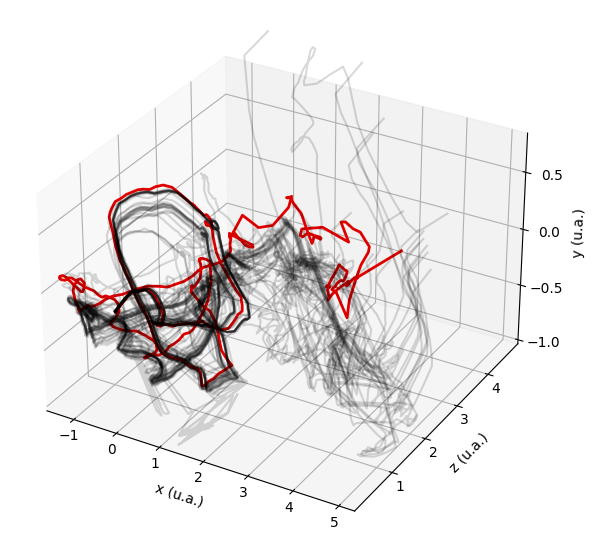

In [ ]:
folders = sorted(glob('./results/*'))

positions = []
for folder in folders:
    data = np.loadtxt(f'{folder}/poses_pred.txt', comments="#")
    positions.append(data[:, 1:4])

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d', computed_zorder=False)

for i, _ in enumerate(positions):
    x, y, z = positions[i][:, 0], positions[i][:, 2], -positions[i][:, 1]
    ax.plot(x, y, z, 'k-', alpha=0.15, zorder=2)
ax.set_xlabel('x (u.a.)', labelpad=-2)
ax.set_ylabel('z (u.a.)', labelpad=-2)
ax.set_zlabel('y (u.a.)')
ax.set_xlim(-1.5, 5.2)
ax.set_ylim(0, 5)
ax.set_zlim(-1, 0.8)
ax.set_ylim(0.01, 4.9)
ax.set_xticks([-1, 0, 1, 2, 3, 4, 5])
ax.set_yticks([1, 2, 3, 4])
ax.set_zticks([-1, -0.5, 0, 0.5])
ax.set_box_aspect([1, 1, 0.7])
ax.view_init(elev=30)
ax.tick_params(axis='x', pad=-3)
ax.tick_params(axis='y', pad=-3)

data = np.loadtxt(f'./results/exp_02062026_14:04:40/poses_pred.txt', comments="#")
positions = data[:, 1:4]
x, y, z = positions[:, 0], positions[:, 2], -positions[:, 1]
ax.plot(x, y, z, 'r-', lw=2, zorder=1)

# Empty ax for extra left padding
ax = fig.add_subplot([0.85, 0.5, 0.1, 0.1])
ax.set_axis_off()

fig.savefig(
    './results/camera_poses_uncertainty.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)

#### Frame-to-frame translation and rotation

Mean translation: 0.058151535830664444
Std translation: 0.13214981230860512
Max translation spike: 1.6926672315360158
Mean rotation (deg): 0.3537376778659028
Smoothness: 0.11534539849489038


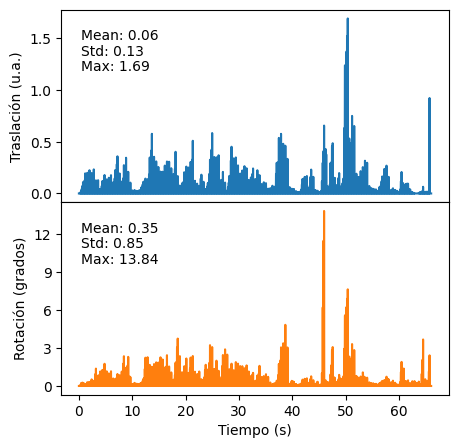

In [ ]:
poses = load_poses('./results/exp_02062026_14:04:40/poses.pickle')
dt, dtheta = relative_motion(poses)

fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(np.linspace(0, 66, len(dt)), dt)
ax[0].set_xticks([])
ax[0].set_ylabel('Traslación (u.a.)')
ax[0].text(
    0.05,
    0.9,
    f'Mean: {dt.mean():.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[0].text(
    0.05,
    0.82,
    f'Std: {dt.std():.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[0].text(
    0.05,
    0.74,
    f'Max: {dt.max():.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[1].plot(np.linspace(0, 66, len(dt)), dtheta, c='tab:orange')
ax[1].set_yticks([0, 3, 6, 9, 12])
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Rotación (grados)')
ax[1].text(
    0.05,
    0.9,
    f'Mean: {dtheta.mean():.2f}',
    va='top',
    transform=ax[1].transAxes
)
ax[1].text(
    0.05,
    0.82,
    f'Std: {dtheta.std():.2f}',
    va='top',
    transform=ax[1].transAxes
)
ax[1].text(
    0.05,
    0.74,
    f'Max: {dtheta.max():.2f}',
    va='top',
    transform=ax[1].transAxes
)

fig.subplots_adjust(hspace=0)
fig.savefig(
    './results/stats_main.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)

#### Multiple frame-to-frame translation and rotation

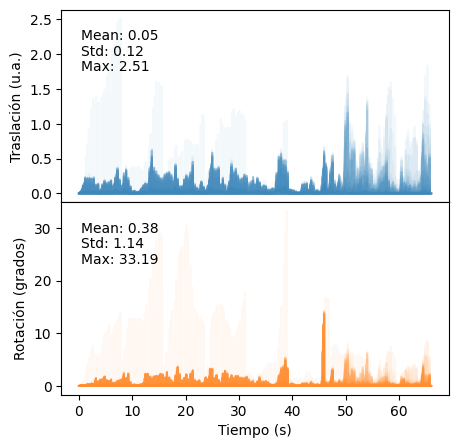

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(5, 5))
dts, dthetas = [], []
folders = sorted(glob('./results/*'))[1:]
for folder in folders:
    poses = load_poses(f'{folder}/poses.pickle')
    dt, dtheta = relative_motion(poses)
    dts.append(dt)
    dthetas.append(dtheta)
    ax[0].plot(np.linspace(0, 66, len(dt)), dt, c='tab:blue', alpha=0.05)
    ax[1].plot(np.linspace(0, 66, len(dt)), dtheta, c='tab:orange', alpha=0.05)
    
ax[0].set_xticks([])
ax[0].set_ylabel('Traslación (u.a.)')
ax[0].text(
    0.05,
    0.9,
    f'Mean: {np.mean(dts):.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[0].text(
    0.05,
    0.82,
    f'Std: {np.std(dts):.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[0].text(
    0.05,
    0.74,
    f'Max: {np.max(dts):.2f}',
    va='top',
    transform=ax[0].transAxes
)
ax[1].set_xlabel('Tiempo (s)')
ax[1].set_ylabel('Rotación (grados)')
ax[1].text(
    0.05,
    0.9,
    f'Mean: {np.mean(dthetas):.2f}',
    va='top',
    transform=ax[1].transAxes
)
ax[1].text(
    0.05,
    0.82,
    f'Std: {np.std(dthetas):.2f}',
    va='top',
    transform=ax[1].transAxes
)
ax[1].text(
    0.05,
    0.74,
    f'Max: {np.max(dthetas):.2f}',
    va='top',
    transform=ax[1].transAxes
)

fig.subplots_adjust(hspace=0)
fig.savefig(
    './results/stats_all.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)

#### Frame preprocessing

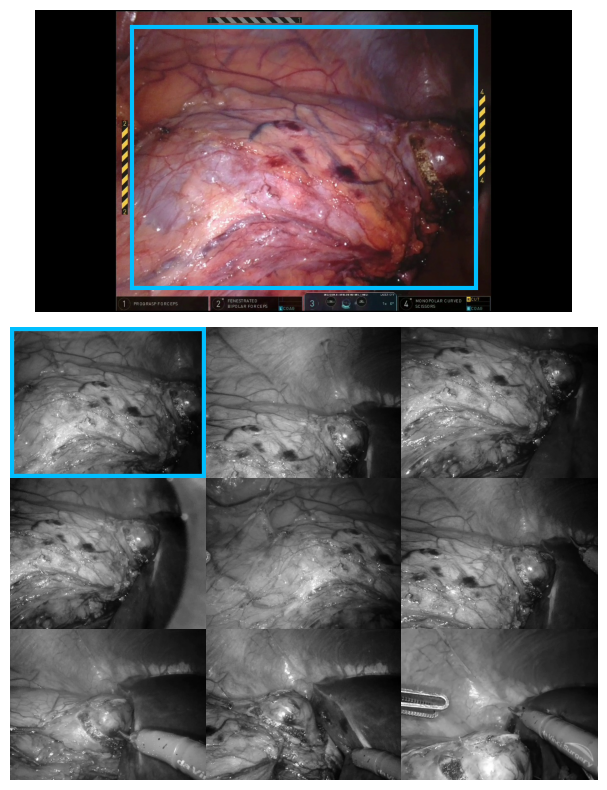

In [ ]:
fullimage = Image.open('../cella_dataset_nocrop/images/00000100.jpg')
cropimages = [
    Image.open(f'../cella_dataset/images/{i:08d}.jpg').convert('L')
    for i in np.linspace(100, 1965, 9, dtype=int)
]

fig, ax = plt.subplot_mosaic(
    """
    aaa
    aaa
    ...
    bcd
    efg
    hij
    """,
    figsize=(10, 10), height_ratios=[1, 1, 0.1, 1, 1, 1]
)

ax['a'].imshow(fullimage)
ax['b'].imshow(cropimages[0], cmap='binary_r')
ax['c'].imshow(cropimages[1], cmap='binary_r')
ax['d'].imshow(cropimages[2], cmap='binary_r')
ax['e'].imshow(cropimages[3], cmap='binary_r')
ax['f'].imshow(cropimages[4], cmap='binary_r')
ax['g'].imshow(cropimages[5], cmap='binary_r')
ax['h'].imshow(cropimages[6], cmap='binary_r')
ax['i'].imshow(cropimages[7], cmap='binary_r')
ax['j'].imshow(cropimages[8], cmap='binary_r')

ax['a'].add_patch(plt.Rectangle(
    (0.18, 0.08),
    0.64, 0.865,
    fc='none',
    ec='deepskyblue',
    lw=3,
    transform=ax['a'].transAxes))
ax['b'].add_patch(plt.Rectangle(
    (0, 0),
    1, 1,
    fc='none',
    ec='deepskyblue',
    lw=6,
    transform=ax['b'].transAxes))

for a in ax:
    ax[a].set_axis_off()

fig.subplots_adjust(wspace=-0.49, hspace=0)
fig.savefig(
    './results/cropimages.png',
    dpi=200,
    bbox_inches='tight',
    pad_inches=0.01
)